In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import sys


sys.path.insert(1, '/Users/michaelreitman/github/REprofile/scripts') #points to scripts folder
from downloadhomologfastas import downloadhomologfastas 
import arrangeoutputfastas as aof
import fcrl
from analyzecountedAAs import analyzecountedAAs
import plotrepeats as pr



In [ ]:
#get date for appending to filenames 
today = datetime.today().strftime('%Y%m%d') 

In [ ]:
#download blast hits 
blast_filepath = "../results/homology_results/dREhomologs_20230802.csv" #points to csv of all homologs that contains a column with the header "gene"
output_folder = = "../results/refseq_fastas"
downloadhomologfastas(blast_filepath,output_folder,overwrite=False)

#manually run the "Pulling" notebooks to pull i 

#arrange results
aof.arrangefastas(output_folder)

In [ ]:
## Amino Acid counting

#count blast refseq amino acid repeats and save
results_folder = "../results/refseq_fastas"
output_folder = os.path.join("../",results_folder.split("/")[1], "counted_AAs","BLAST_refseq")
fcrl.fcrlwrapper(results_folder, output_folder,MRget=True)

#count BLAST Genbank amino acid repeats and save
results_folder = "../results/BLAST_Genbank_aa_fastas"
output_folder = os.path.join("../",results_folder.split("/")[1], "counted_AAs","BLAST_genbank")
fcrl.fcrlwrapper(results_folder, output_folder)

#count structural similarity amino acid repeats and save
results_folder = "../results/Foldseek_aa_fastas"
output_folder = os.path.join("../",results_folder.split("/")[1], "counted_AAs", "structural_similarity")
fcrl.fcrlwrapper(results_folder, output_folder)

In [ ]:
#combine the Refseq and Genbank counts
refseq_folder = "../results/countedAAs/BLAST_refseq"
genbank_folder = "../results/countedAAs/BLAST_genbank"
output_folder = "../results/countedAAs/total"
databases = ["refseq","genbank"]

fcrl.combinecounts(refseq_folder,genbank_folder,output_folder,databases)

#combine the BLAST counts and structural similarity counts
results_folder = "../results/countedAAs/total"
foldseek_folder = "../results/countedAA/structural_similarity"
output_folder = "../results/countedAAs/total"
databases = ["BLAST","structural similarity"]

fcrl.combinecounts(results_folder,foldseek_folder,output_folder,databases)

In [ ]:
#combine the BLAST homology results and structural similarity results
ss_file_path = "../results/homology_results/dREstuct_similarity_20230717.tsv"
blast_file_path = "../results/homology_results/dREhomologs_20230718.csv"
output_folder = "../results/homology_results"
homolog_df = pd.read_table(ss_file_path)
blast_df = pd.read_csv(blast_file_path)

homolog_df.rename(columns={
    "protid":"Accession",
    "organism.scientificName":"Scientific Name",
    "organism.commonName":"Common Name",
    "sequence.length":"Acc. Len",
    "organism.taxonId":"Taxid",
    },inplace=True)

#remove hits that came from blast because we blasted seperately as well
homolog_df = homolog_df[homolog_df["source.method"].str.contains('foldseek')]
homolog_df["source.method"]='foldseek'

#drop any duplicates 
homolog_df["gene"] = homolog_df["reference"].str.split('_').str[0]
homolog_df.drop_duplicates(subset = ["Accession"],inplace=True)
homolog_df.reset_index(inplace=True,drop=True)

#only keep results with TM score >0.2
homolog_df = homolog_df[homolog_df["TM_v_query"]>0.2]

full_df = pd.concat([blast_df ,homolog_df], axis=0, ignore_index=True)
full_df.to_csv(os.path.join(output_folder,"full_results_" + today + ".csv"))

In [ ]:
#analyze the amino acid repeats, combine with homology results, and save the results in a new folder (per gene) 
countedAAs_folder = "../results/counted_AAs/total"
output_path =  "../results/analyzed_AAcounts"
homology_file_path = "../results/homology_results/full_results_20230802.csv"

analyzecountedAAs(input_dir = countedAAs_folder, 
output_path = output_path, 
homology_file_path=homology_file_path 
)

In [ ]:
#plot the repeat counting results for each set of disease-associated repeat expansion gene homologs
folder = "../results/analyzed_AAcounts"
pr.plot_analyzed_AAcounts(folder)

In [ ]:
# plot the repeat lengths for all the coding disease-associated repeat expansion homologs together 
all_AA_reps_path = "../results/analyzed_AAcounts/all_pathologic_AA_repeats.csv"
all_AA_reps = pd.read_csv(all_AA_reps_path)
comparison_metric = "Human Normal Max Delta"

#filter to keep only the longest homolog per organism
all_AA_reps = all_AA_reps.sort_values('Length', ascending=False).drop_duplicates(subset = ['gene','Scientific Name']).sort_index()
pr.plot_allDRE_pathologicalAA(all_AA_reps,comparison_metric)
plt.ylim([-50,25])

output_folder = "../results/plots"

plt.savefig(os.path.join(output_folder,'codingdREs_relmaxhumanrepeats_'+today+'.svg'), format='svg', dpi=1200)
plt.savefig(os.path.join(output_folder,'codingdREs_relmaxhumanrepeats_'+today+'.pdf'), format='pdf', dpi=1200)

Taxid     Common Name               
42254.0   European shrew                13
10041.0   white-footed mouse            13
9597.0    pygmy chimpanzee              12
109475.0  white-toothed pygmy shrew     12
60711.0   green monkey                  12
105255.0  banner-tailed kangaroo rat    12
36803.0   cinereus shrew                12
591936.0  Ugandan red Colobus           11
9601.0    Sumatran orangutan            11
9925.0    goat                          11
Name: count, dtype: int64


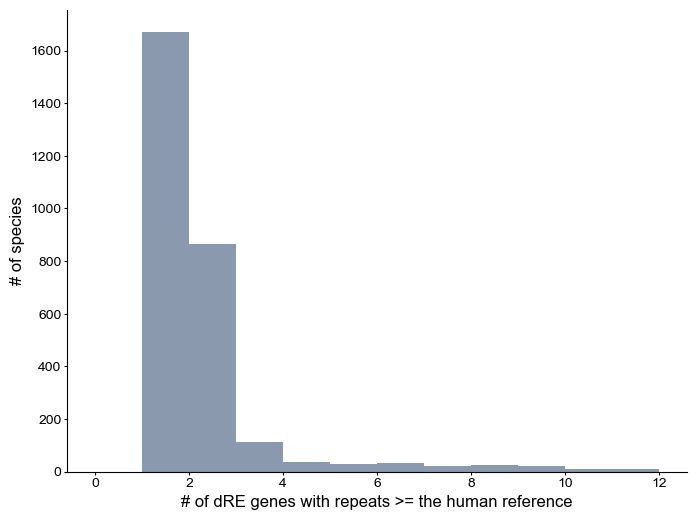

In [57]:
#look at the number of homologs with repeats >= the human reference for each species,
#and save the count with corresponding taxid for plotting on a taxonomic tree

all_hit_species_path = "../results/analyzed_AAcounts/all_hit_species.csv"
all_hit_species = pd.read_csv(all_hit_species_path)

#filter so each species only has one hit per dRE
all_hit_species = all_hit_species.sort_values('Length', ascending=False).drop_duplicates(subset = ['gene','Scientific Name']).sort_index()

#fill in a common name if the organism doesn't have one
all_hit_species["Common Name"].fillna(all_hit_species["Scientific Name"],inplace=True)

#count how many homolgs each species has
dRE_count_by_species= all_hit_species[['Taxid','Common Name']].value_counts()

#plot how many homologs species have with repeats that match or exceed the human reference
bins = range(0,dRE_count_by_species.max(),1)
plt.subplots(figsize=(8,6))
plt.hist(dRE_count_by_species,bins=bins,color="arcadia:marineblue")
plt.xlabel('# of dRE genes with repeats >= the human reference')
plt.ylabel('# of species')

print(dRE_count_by_species.iloc[0:10])

filename = "../results/taxidcounts_for_treemapping/taxid_ndREhits_" + today + ".csv"
dRE_count_by_species.to_csv(filename)

In [58]:
#find species with homologs that would be interesting for disease modeling or might have molecular solutions

temp = all_hit_species.copy()

#warning:
#For NIPA1 the reference genome contains more repeats than normal max.
# JPH3 assessement is challenging because the repeat happens from an anti-sense transcript

#data exclusion:
#for HOXD13/ZIC3, many homologs are HOXA13/ZIC2 proteins which have longer repetitive tracts and thus gives false positives
#therefore we exclude those homologs from our analyis

temp = temp[~temp["gene"].str.contains("ZIC3|HOXD13")]

pathogenicmin_dRE_species = temp[temp["Human Pathogenic Min Delta"] >= 0]
normalmax_dRE_species = temp[temp["Human Normal Max Delta"] > 0]

#take a look at which species have "pathogenic" looking repeats in their reference homologs! Big if true!
print(pathogenicmin_dRE_species[['Taxid','Scientific Name','Common Name',"gene","Human Pathogenic Min Delta", "Per. Ident","TM_v_query"]].sort_values("gene"))

          Taxid             Scientific Name                 Common Name  \
18631  109478.0             Myotis brandtii                Brandt's bat   
18632    9662.0                 Meles meles             Eurasian badger   
18633   29082.0  Macroscelides proboscideus  short-eared elephant shrew   
18634  107270.0    Brachytarsomys albicauda            white-tailed rat   
18869    9305.0        Sarcophilus harrisii             Tasmanian devil   
...         ...                         ...                         ...   
18444  299123.0  Lonchura striata domestica             Bengalese finch   
18801  109905.0           Chelmon rostratus    copperband butterflyfish   
18800    9669.0       Mustela putorius furo             domestic ferret   
3044    10181.0       Heterocephalus glaber              naked mole-rat   
18365  109478.0             Myotis brandtii                Brandt's bat   

         gene  Human Pathogenic Min Delta  Per. Ident  TM_v_query  
18631      AR                  

In [38]:
#look if there are any species with multiple repeat expanded homologs with repeats > the healthy human limit
healthy_human_max = normalmax_dRE_species[['Taxid','Common Name']].value_counts()
filename = "../results/taxidcounts_for_treemapping/taxid_exceeds_healthy_human_max_" + today + ".csv"
# healthy_human_max.to_csv(filename)

Taxid     Common Name              
9261.0    Australian echidna           5
9305.0    Tasmanian devil              4
38626.0   koala                        4
9337.0    common brushtail             4
38775.0   yellow-footed antechinus     4
33562.0   monito del monte             4
214514.0  Pacific pocket mouse         3
9662.0    Eurasian badger              3
59472.0   Kuhl's pipistrelle           3
13616.0   gray short-tailed opossum    3
Name: count, dtype: int64


In [ ]:
#use z-scoring as an alternative way to find interesting species for further exploration

mean_lengthZscore = normalmax_dRE_species[["Taxid","Length Zscore"]].groupby("Taxid").mean().sort_values("Length Zscore", ascending=False)
summed_lengthZscore = normalmax_dRE_species[["Taxid","Length Zscore"]].groupby("Taxid").sum().sort_values("Length Zscore", ascending=False)

print(summed_lengthZscore.iloc[0:25])

filename = "../results/taxidcounts_for_treemapping/taxid_exceeds_healthy_max_summed_length_zscore_" + today + ".csv"
summed_lengthZscore.to_csv(filename)

filename = "../results/taxidcounts_for_treemapping/taxid_exceeds_healthy_max_mean_length_zscore_" + today + ".csv"
mean_lengthZscore.to_csv(filename)

In [ ]:
#make a binary table for heatmap plotting 
binary_table = pd.crosstab(normalmax_dRE_species['Common Name'], normalmax_dRE_species['gene']).clip(upper=1)
binary_table.to_csv("../results/taxidcounts_for_treemapping/binarized_taxid_exceeds_healthy_human_max_" + today + ".csv")

In [37]:
#take specific species for labeling on violin plot
select_species = all_hit_species[all_hit_species["Common Name"].str.contains(
    "Australian echidna|Kuhl's pipistrelle|cinereus shrew|Pacific pocket mouse|sea lamprey",
    na=False)]
select_species = select_species[["Common Name","Taxid","gene","Human Normal Max Delta"]]

output_path = "../results/plots/select_species_for_violin_plot"+ today + ".csv"
select_species.sort_values(by="Common Name").to_csv(output_path)